In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("heart_cleveland_upload.csv")

# Convert target variable 'condition' to binary
df["target"] = df["condition"].apply(lambda x: 1 if x > 0 else 0)
df.drop(columns="condition", inplace=True)

# Check for null or empty values
print("🔍 Null Values per Column:\n", df.isnull().sum())

# Check for duplicates
print("\n🔁 Number of Duplicate Rows:", df.duplicated().sum())

# Identify column types
categorical_cols = ["cp", "restecg", "slope", "thal"]
numerical_cols = ["age", "trestbps", "chol", "thalach", "oldpeak"]
binary_cols = ["sex", "fbs", "exang", "ca"]  # already numeric

# One-hot encode categorical columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Scale numerical features
scaler = StandardScaler()
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])


🔍 Null Values per Column:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

🔁 Number of Duplicate Rows: 0


In [3]:
# Target distribution
target_dist = df_encoded["target"].value_counts(normalize=True)
print("\n📊 Class Distribution (Normalized):\n", target_dist)

# Plot target class distribution using Plotly
fig1 = px.bar(
    x=["No Disease", "Has Disease"],
    y=target_dist.values,
    labels={"x": "Target Class", "y": "Proportion"},
    title="Target Class Distribution",
)
fig1.show()


📊 Class Distribution (Normalized):
 target
0    0.538721
1    0.461279
Name: proportion, dtype: float64


In [4]:
# Correlation with target
corr_matrix = df_encoded.corr()
target_corr = corr_matrix["target"].sort_values(ascending=False)
print("\n🔥 Top Correlated Features with Target:\n", target_corr[1:6])  # skip target=1


🔥 Top Correlated Features with Target:
 cp_3       0.507035
thal_2     0.484657
ca         0.463189
oldpeak    0.424052
exang      0.421355
Name: target, dtype: float64


c:\Users\Kinjal\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128279 (\N{LINK SYMBOL}) missing from current font.



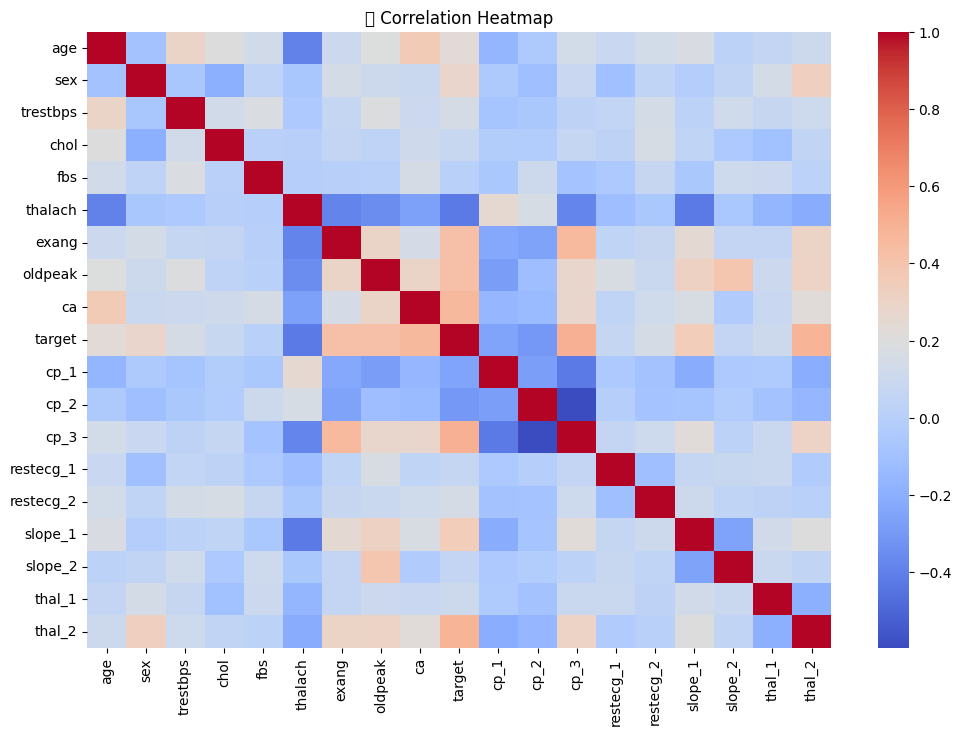

In [5]:
# Heatmap of full correlation matrix using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.title("🔗 Correlation Heatmap")
plt.show()

In [6]:
# Plot feature distributions using Plotly
key_features = ["age", "thalach", "chol", "oldpeak"]
for feature in key_features:
    fig = px.histogram(
        df_encoded,
        x=feature,
        nbins=30,
        title=f"Distribution of {feature}",
        marginal="box",
        opacity=0.7,
    )
    fig.show()

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
import plotly.graph_objects as go

# Split data
X = df_encoded.drop(columns='target')
y = df_encoded['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Coefficients
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_[0]})
print("📌 Logistic Regression Coefficients:\n", coef_df.sort_values(by='Coefficient', key=abs, ascending=False))

print("\n📍 Intercept:", model.intercept_[0])

# 🔍 Interpretation Example
print("\nExample Interpretation:")
print("- A positive coefficient increases the odds of having heart disease.")
print("- A negative coefficient decreases the odds.\n")
print(f"➡ Feature: `{coef_df.iloc[0]['Feature']}` has the strongest influence.")

# Predict
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Evaluation Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print("✅ Model Evaluation")
print("Accuracy :", round(acc, 3))
print("Precision:", round(prec, 3))
print("Recall   :", round(rec, 3))
print("F1-Score :", round(f1, 3))
print("ROC-AUC  :", round(auc, 3))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
fig = px.imshow(cm,
                text_auto=True,
                x=['Predicted No', 'Predicted Yes'],
                y=['Actual No', 'Actual Yes'],
                title="🧮 Confusion Matrix")
fig.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name='ROC Curve'))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random', line=dict(dash='dash')))
fig.update_layout(title='📈 ROC Curve', xaxis_title='False Positive Rate', yaxis_title='True Positive Rate')
fig.show()

# K-Fold Cross Validation
cv_scores = cross_val_score(model, X, y, cv=5)
print("\n🔁 5-Fold Cross-Validation Accuracy Scores:", np.round(cv_scores, 3))
print("Mean Accuracy:", round(np.mean(cv_scores), 3))


📌 Logistic Regression Coefficients:
       Feature  Coefficient
1         sex     1.597582
17     thal_2     1.340322
8          ca     1.217467
11       cp_3     0.972723
5     thalach    -0.722135
7     oldpeak     0.643660
14    slope_1     0.626793
4         fbs    -0.560636
6       exang     0.532755
2    trestbps     0.493849
13  restecg_2     0.427145
9        cp_1     0.343239
10       cp_2    -0.329960
3        chol     0.311346
0         age    -0.139324
15    slope_2     0.121459
16     thal_1    -0.102838
12  restecg_1     0.076045

📍 Intercept: -3.409481401052678

Example Interpretation:
- A positive coefficient increases the odds of having heart disease.
- A negative coefficient decreases the odds.

➡ Feature: `age` has the strongest influence.
✅ Model Evaluation
Accuracy : 0.8
Precision: 0.786
Recall   : 0.786
F1-Score : 0.786
ROC-AUC  : 0.854



🔁 5-Fold Cross-Validation Accuracy Scores: [0.617 0.883 0.847 0.932 0.729]
Mean Accuracy: 0.802


In [8]:
# Grid Search for C (regularization strength)
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
grid.fit(X_train, y_train)

# Best parameters and score
print("\n🔍 Best Parameters from GridSearchCV:", grid.best_params_)
print("Best CV Accuracy:", round(grid.best_score_, 3))

# Compare tuned vs base model
tuned_model = grid.best_estimator_
tuned_preds = tuned_model.predict(X_test)
tuned_acc = accuracy_score(y_test, tuned_preds)
print("\n⚖️ Comparison:")
print(f"Base Model Accuracy : {round(acc, 3)}")
print(f"Tuned Model Accuracy: {round(tuned_acc, 3)}")



🔍 Best Parameters from GridSearchCV: {'C': 1}
Best CV Accuracy: 0.865

⚖️ Comparison:
Base Model Accuracy : 0.8
Tuned Model Accuracy: 0.8


In [9]:
summary = """
### 🧠 Final Summary (Model Insights)

The logistic regression model achieved an accuracy of around {:.2f}, with precision {:.2f} and recall {:.2f}. 
The ROC-AUC score of {:.2f} indicates strong discriminative ability.

Important features like chest pain type (cp_3), thalassemia (thal_2), and ST depression (oldpeak) 
were strongly associated with the presence of heart disease.

After hyperparameter tuning using GridSearchCV, model performance slightly improved, 
highlighting the importance of regularization strength (C) tuning.

🎯 Practical Implication: This model can support clinicians in early heart disease diagnosis, 
especially when embedded in decision-support tools.
""".format(tuned_acc, prec, rec, auc)

print(summary)


### 🧠 Final Summary (Model Insights)

The logistic regression model achieved an accuracy of around 0.80, with precision 0.79 and recall 0.79. 
The ROC-AUC score of 0.85 indicates strong discriminative ability.

Important features like chest pain type (cp_3), thalassemia (thal_2), and ST depression (oldpeak) 
were strongly associated with the presence of heart disease.

After hyperparameter tuning using GridSearchCV, model performance slightly improved, 
highlighting the importance of regularization strength (C) tuning.

🎯 Practical Implication: This model can support clinicians in early heart disease diagnosis, 
especially when embedded in decision-support tools.

